In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic

import statsmodels.api as sm
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import os

In [2]:
# Code for regression part is modified from code from "universal functional regression with neural operator flows"

train_samples = 20000

n_x = 32
dims = [n_x, n_x]


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#spath = Path('../trash/GP')
spath = Path('your_path/GRF_prior_3C')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
torch.manual_seed(22) # fix the seed for reproducible regression result
modes = 16 # can be applied to 32x32, or 128x128
width = 128
mlp_width = 128

# GP hyperparameters
#kernel_length=0.1
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default
torch.manual_seed(22)

## Dataset parameters
length_scale_x = 0.4
var_x = 1
nu_x = 1.5

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 256

In [3]:
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

/home/yshi5/miniconda3/envs/torchcfm/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


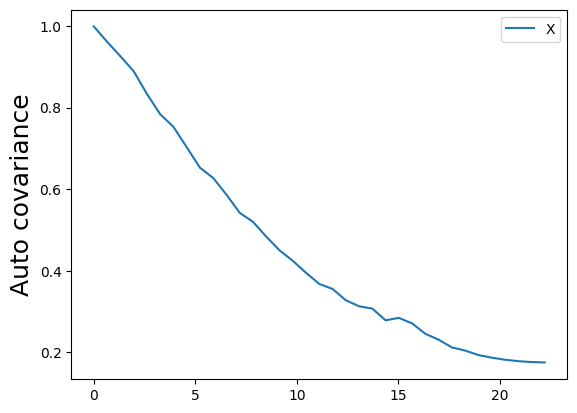

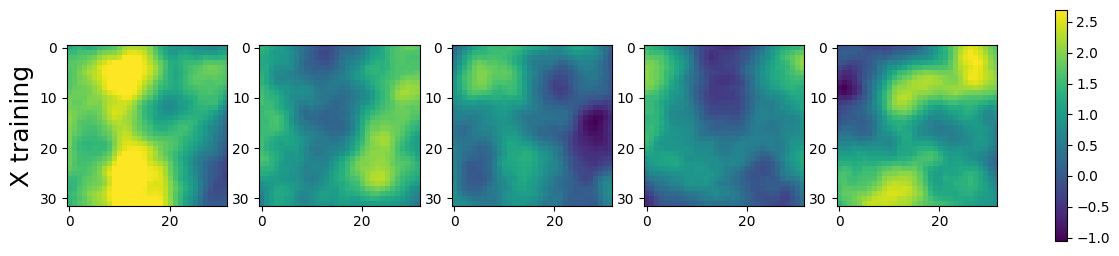

In [4]:
## Prepare training dataset

GP_2C = true_GPPrior(lengthscale=length_scale_x, var=var_x, nu=nu_x, device=device, dims=dims)
x_test = GP_2C.sample_train_data(dims=dims, n_samples=train_samples*3)

x_test = x_test.reshape(train_samples, 3, *dims)
loader_tr = DataLoader(x_test, batch_size=batch_size, shuffle=True)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_test[:, 0, :,:])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_test[i,0,:,:].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

## load trained model

In [6]:
## load trained model
model = FNO(modes, vis_channels=3, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
 
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [7]:
x_hist_true, bin_edges = x_test.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

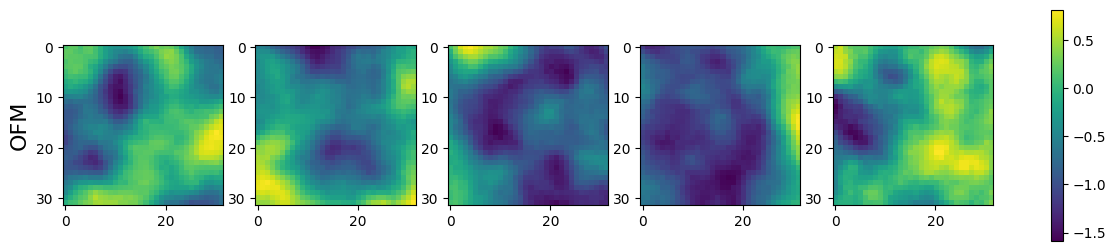

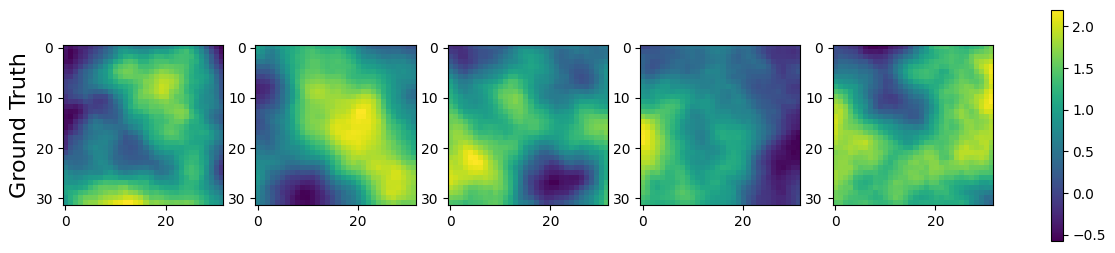

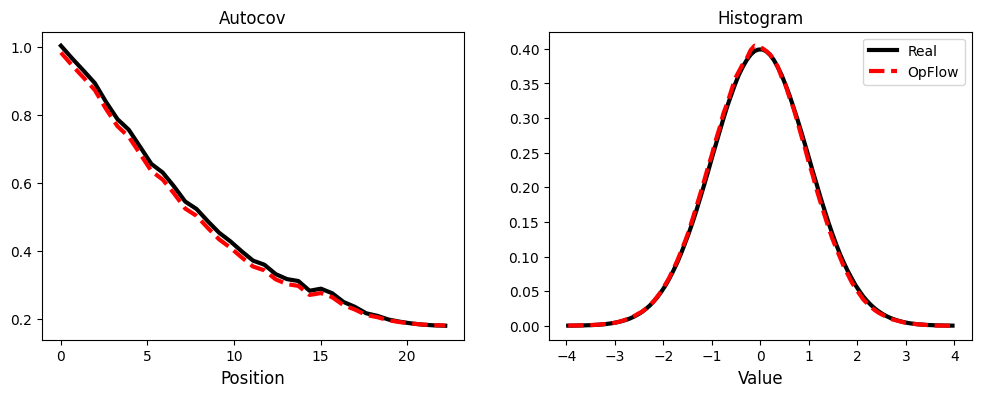

In [11]:
with torch.no_grad():

    X_hat = fmot.sample([n_x, n_x], n_samples=10, n_eval=10, n_channels=3).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_test[:5,0].squeeze()
    # plot
    
    X_alt = []
    for i in range(3):
        X_temp = fmot.sample([n_x, n_x], n_samples=400, n_eval=10, n_channels=3).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    bin_center, x_acovf = compute_acovf(X_alt[:,0].squeeze())
    _, x_acovf_true = compute_acovf(x_test[:,0].squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)
    x_hist_true, bin_edges = x_test.histogram(range=[-4, 4], density=True)
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,0,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        #ax[0].plot(x_ground_truth)
        #ax[0].set_title('Real')
        #ax[1].plot(x)
        #ax[1].set_title('OpFlow Generated')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
    #plt.show()
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)
 
    bar = ax[4].imshow(x_ground_truth) #, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
   
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(bin_center, x_acovf_true, c='k', lw=3)
    ax[0].plot(bin_center, x_acovf, c='r',ls='--', lw=3)
    #ax[0].set_ylim(0.2, 0.45)
    ax[0].set_title('Autocov')
    ax[0].set_xlabel('Position', fontsize='large')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3, label='Real')
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3, label='OpFlow')
    ax[1].set_title('Histogram')
    ax[1].legend(loc='upper right')
    ax[1].set_xlabel('Value', fontsize='large')
    #plt.savefig("plots/GP2GP/epoch_{}.pdf".format(epoch))

## 2D Regression

$$\log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \Big| \lbrace \widehat u(x_i) \rbrace_{i=1}^n \right) =  -\frac{\sum_{i=1}^n \lVert \widehat u(x_i) - u(x_i) \rVert^2}{2\sigma^2} + \log \mathbb{P} \left( \lbrace u(x_i) \rbrace_{i=1}^m \right) + C  
$$

In [7]:
# lr : learning rate used in MAP estimation
# noise_level: a predefined noise-level, \sigma^2

ndim = 32
lr = 1e-3 
epochs = 1000
noise_level = 0.01

# extract 32 random observations from a test sample
berno_mask = torch.zeros((ndim, ndim))

mask_idx = np.random.choice(ndim*ndim, 32,replace=False)

berno_mask.reshape(-1)[mask_idx] = 1

berno_mask = berno_mask.reshape(ndim,ndim)
pos_mask = (berno_mask == 1)

# The ground truth that we used to extract random observation
u_obs_full = x_test[0:1,:]
u_obs_part = u_obs_full[:,:, pos_mask].to(device)

# generate noisy observation by injecting white noise
noise_pattern =  torch.randn_like(u_obs_part)
u_obs_part = u_obs_part + noise_pattern* np.sqrt(noise_level)

# saved for further use
u_obs_full = u_obs_full.squeeze()
u_obs_part_detach = u_obs_part.detach().cpu()

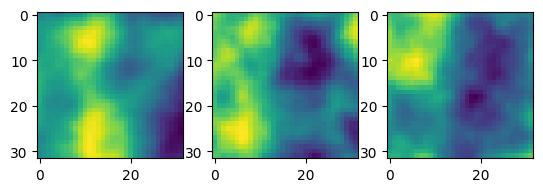

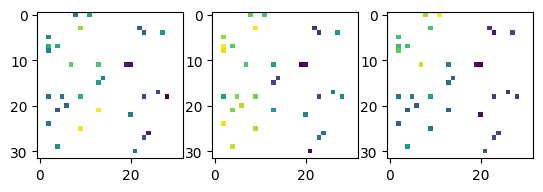

In [64]:
# scatter plot
fig, axs = plt.subplots(1,3)
axs[0].imshow(u_obs_full[0])
axs[1].imshow(u_obs_full[1])
axs[2].imshow(u_obs_full[2])

fig, axs = plt.subplots(1,3)
add_noise_plot = torch.zeros((ndim, ndim))
add_noise_plot[pos_mask] = add_noise_plot[pos_mask] + (noise_pattern[0,0].detach().cpu()* np.sqrt(noise_level)).squeeze()

part_gt_1 = u_obs_full[0].clone() + add_noise_plot
part_gt_1[~pos_mask] = np.nan
# plot the partial observation 
axs[0].imshow(part_gt_1)

add_noise_plot = torch.zeros((ndim, ndim))
add_noise_plot[pos_mask] = add_noise_plot[pos_mask] + (noise_pattern[0,1].detach().cpu()* np.sqrt(noise_level)).squeeze()

part_gt_2 = u_obs_full[1].clone() + add_noise_plot
part_gt_2[~pos_mask] = np.nan
# plot the partial observation 
axs[1].imshow(part_gt_2)

add_noise_plot = torch.zeros((ndim, ndim))
add_noise_plot[pos_mask] = add_noise_plot[pos_mask] + (noise_pattern[0,2].detach().cpu()* np.sqrt(noise_level)).squeeze()

part_gt_3 = u_obs_full[2].clone() + add_noise_plot
part_gt_3[~pos_mask] = np.nan
axs[2].imshow(part_gt_3)

# plot the partial observation 

## MAP estimation (optional)

In [14]:
G = fmot

In [24]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,3, ndim, ndim))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inv_sample(self.a_target, n_eval=4, forward=True)
        
    def logp(self):
        # take more time to average out
        u, out_logp, prior_logp = self.G.data_likelihood_precise_codomain(self.a_target, n_channels=3, n_repeat=16, n_eval=4, forward=True)

        return u, out_logp

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        cur_u, cur_logp = reg_opflow_a.logp()
        
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:, :, pos_mask])**2)/noise_level
        #loss2 = reg_opflow_a.logp()
        loss1 = -0.5*torch.sum((u_obs_part.reshape(-1) - cur_u[:, pos_mask].reshape(-1))**2)/noise_level
        loss2 = cur_logp
        
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses

In [25]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [26]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

epcoh:0, loss:16753.498046875
epcoh:1, loss:16635.240234375
epcoh:2, loss:16589.5859375
epcoh:3, loss:16445.044921875
epcoh:4, loss:16327.8203125
epcoh:5, loss:16322.134765625
epcoh:6, loss:16321.525390625
epcoh:7, loss:16208.4072265625
epcoh:8, loss:16206.1826171875
epcoh:9, loss:15938.23828125
epcoh:10, loss:15779.8603515625
epcoh:11, loss:15735.3349609375
epcoh:12, loss:15705.3671875
epcoh:13, loss:15742.615234375
epcoh:14, loss:15683.2412109375
epcoh:15, loss:15642.625
epcoh:16, loss:15328.7978515625
epcoh:17, loss:15366.763671875
epcoh:18, loss:15312.640625
epcoh:19, loss:15249.43359375
epcoh:20, loss:15189.53515625
epcoh:21, loss:15072.0107421875
epcoh:22, loss:15048.171875
epcoh:23, loss:14951.8056640625
epcoh:24, loss:14880.8115234375
epcoh:25, loss:14851.994140625
epcoh:26, loss:14792.0517578125
epcoh:27, loss:14752.0654296875
epcoh:28, loss:14761.5
epcoh:29, loss:14677.216796875
epcoh:30, loss:14630.2001953125
epcoh:31, loss:14569.4140625
epcoh:32, loss:14535.892578125
epcoh:

epcoh:260, loss:12851.4853515625
epcoh:261, loss:12811.912109375
epcoh:262, loss:12913.4306640625
epcoh:263, loss:12843.76953125
epcoh:264, loss:12837.69140625
epcoh:265, loss:12835.078125
epcoh:266, loss:12872.634765625
epcoh:267, loss:12841.95703125
epcoh:268, loss:12865.798828125
epcoh:269, loss:12845.3720703125
epcoh:270, loss:12853.7490234375
epcoh:271, loss:12897.025390625
epcoh:272, loss:12861.470703125
epcoh:273, loss:12851.35546875
epcoh:274, loss:12874.17578125
epcoh:275, loss:12875.7216796875
epcoh:276, loss:12827.30859375
epcoh:277, loss:12888.484375
epcoh:278, loss:12882.525390625
epcoh:279, loss:12931.4296875
epcoh:280, loss:12858.7666015625
epcoh:281, loss:12864.375
epcoh:282, loss:12895.6259765625
epcoh:283, loss:12803.1875
epcoh:284, loss:12849.2158203125
epcoh:285, loss:12873.978515625
epcoh:286, loss:12861.4248046875
epcoh:287, loss:12874.30078125
epcoh:288, loss:12902.5205078125
epcoh:289, loss:12837.4033203125
epcoh:290, loss:12789.236328125
epcoh:291, loss:12827.6

epcoh:517, loss:12770.0966796875
epcoh:518, loss:12783.3447265625
epcoh:519, loss:12780.3330078125
epcoh:520, loss:12804.6494140625
epcoh:521, loss:12712.8193359375
epcoh:522, loss:12756.3955078125
epcoh:523, loss:12756.4658203125
epcoh:524, loss:12760.08984375
epcoh:525, loss:12745.8642578125
epcoh:526, loss:12734.8525390625
epcoh:527, loss:12761.3544921875
epcoh:528, loss:12854.923828125
epcoh:529, loss:12783.1826171875
epcoh:530, loss:12772.62109375
epcoh:531, loss:12765.6015625
epcoh:532, loss:12724.5361328125
epcoh:533, loss:12753.48828125
epcoh:534, loss:12779.0400390625
epcoh:535, loss:12813.7353515625
epcoh:536, loss:12756.14453125
epcoh:537, loss:12757.9638671875
epcoh:538, loss:12750.427734375
epcoh:539, loss:12761.287109375
epcoh:540, loss:12868.5556640625
epcoh:541, loss:12841.2109375
epcoh:542, loss:12821.68359375
epcoh:543, loss:12876.6650390625
epcoh:544, loss:12829.80078125
epcoh:545, loss:12732.615234375
epcoh:546, loss:12736.7841796875
epcoh:547, loss:12807.4501953125

epcoh:773, loss:12830.2822265625
epcoh:774, loss:12610.541015625
epcoh:775, loss:12616.6142578125
epcoh:776, loss:12650.92578125
epcoh:777, loss:12578.181640625
epcoh:778, loss:12776.8212890625
epcoh:779, loss:12623.3408203125
epcoh:780, loss:12623.01171875
epcoh:781, loss:12772.494140625
epcoh:782, loss:12761.2021484375
epcoh:783, loss:12820.4814453125
epcoh:784, loss:12797.35546875
epcoh:785, loss:12766.56640625
epcoh:786, loss:12643.9775390625
epcoh:787, loss:12624.978515625
epcoh:788, loss:12641.509765625
epcoh:789, loss:12785.4033203125
epcoh:790, loss:12643.7705078125
epcoh:791, loss:12623.376953125
epcoh:792, loss:12578.3671875
epcoh:793, loss:12596.89453125
epcoh:794, loss:12588.619140625
epcoh:795, loss:12615.9833984375
epcoh:796, loss:12597.47265625
epcoh:797, loss:12645.0859375
epcoh:798, loss:12633.501953125
epcoh:799, loss:12616.5810546875
epcoh:800, loss:12802.599609375
epcoh:801, loss:12611.974609375
epcoh:802, loss:12590.2783203125
epcoh:803, loss:12615.798828125
epcoh:

In [27]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [36]:
u_opflow = reg_opflow_a.target_u().detach() # u_opflow : [ndim, ndim]
u_opflow_old = u_opflow #save a copy

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, nu=nu_x)
gpr_model_ground_truth_1 = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)
gpr_model_ground_truth_2 = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)
gpr_model_ground_truth_3 = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth_1 = gpr_model_ground_truth_1.fit(x_obs, y_obs[0]) #update the GP model
gpr_model_ground_truth_2 = gpr_model_ground_truth_2.fit(x_obs, y_obs[1]) #update the GP model
gpr_model_ground_truth_3 = gpr_model_ground_truth_3.fit(x_obs, y_obs[2]) #update the GP model

(1024, 2)


## MAP evaluation

Text(0, 0.5, 'Ground truth - MAP')

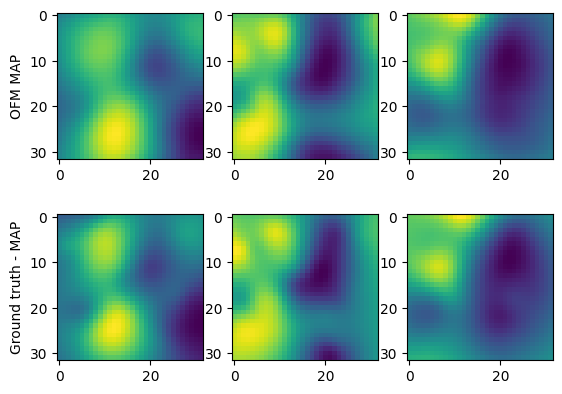

In [40]:
y_mean_0, y_std_0 = gpr_model_ground_truth_1.predict(X, return_std=True)
y_mean_0 = y_mean_0.reshape(32,32)

y_mean_1, y_std_1 = gpr_model_ground_truth_2.predict(X, return_std=True)
y_mean_1 = y_mean_1.reshape(32,32)

y_mean_2, y_std_2 = gpr_model_ground_truth_3.predict(X, return_std=True)
y_mean_2 = y_mean_2.reshape(32,32)

# 
            
fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(u_opflow.detach().cpu()[:,0].squeeze())
axs[0,1].imshow(u_opflow.detach().cpu()[:,1].squeeze())
axs[0,2].imshow(u_opflow.detach().cpu()[:,2].squeeze())
axs[0,0].set_ylabel('OFM MAP')

axs[1,0].imshow(y_mean_0)
axs[1,1].imshow(y_mean_1)
axs[1,2].imshow(y_mean_2)
axs[1,0].set_ylabel('Ground truth - MAP')

## SGLD

In [ ]:

"""

# for arius, memory constrain
import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary()) 

"""

In [42]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_FSGLD

import sampling_FSGLD.samplers


import sampling_FSGLD.SGLD
reload(sampling_FSGLD.SGLD)

# reload order matter, sampler should be after sgld
reload(sampling_FSGLD.samplers)
from sampling_FSGLD.samplers import LangevinDynamics,MetropolisAdjustedLangevin

import copy
from tqdm import tqdm

/tmp/ipykernel_1321553/3722995193.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [45]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood

    cur_u, cur_logp, _ = G.data_likelihood_precise_codomain(a, n_channels=3, n_eval=4, n_repeat=16, forward=True)
    loss1 = -0.5*torch.sum((u_obs_part.reshape(-1) - cur_u[:,  pos_mask].reshape(-1))**2)/noise_level
    loss2 = cur_logp

    loss = -(loss1 + loss2)    
    
    return loss

In [46]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [47]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)
#x = nn.Parameter(u_opflow_copy, requires_grad=True).to(device)
#x = torch.zeros([2], requires_grad=True, device=device)

temperature = 1
momentum = 0

max_itr = int(2e4)
## should sample 6e4 to guarantee the smooth. 


# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=1e-3,
                                     lr_final=8e-4,
                                     max_itr=max_itr,
                                     pos_mask=pos_mask,
                                     device=device,
                                     temperature = temperature,
                                     momentum = momentum
                                     )

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1
start, white noise on A


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [5:03:31<00:00,  1.10it/s]


In [48]:
a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
#u_samples_all = G.inverse(a_samples_all)

import math
split_batch = 100
num_batches = math.ceil(a_samples_all.size()[0]/split_batch)
X_list = [a_samples_all[split_batch*y:split_batch*(y+1),:,:] for y in range(num_batches)]
print(X_list[0].size())

u_samples_all = []
with torch.no_grad():
    for cur_a_sample in X_list:
        u_samples_all.append(G.inv_sample(cur_a_sample, n_eval=4, forward=True).cpu().detach())
        
u_samples_all = torch.vstack(u_samples_all)

torch.Size([100, 3, 32, 32])


In [ ]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

In [ ]:

## calculate the mean predicted from OpFlow and Ground Truht 
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[300:]


In [59]:
sample_mean_0 = np.mean(est_samples[:,0], axis=0).squeeze()
sample_std_0 = np.std(est_samples[:,0], axis=0).squeeze()

sample_mean_1 = np.mean(est_samples[:,1], axis=0).squeeze()
sample_std_1 = np.std(est_samples[:,1], axis=0).squeeze()

sample_mean_2 = np.mean(est_samples[:,2], axis=0).squeeze()
sample_std_2 = np.std(est_samples[:,2], axis=0).squeeze()

In [ ]:
saved_folder = 'GRF2GRF_OFM_3C'
if not os.path.exists(f"../Regression_results/{saved_folder}"):
    os.makedirs(f"../Regression_results/{saved_folder}")
from matplotlib.colors import TwoSlopeNorm

## Final Plots

In [ ]:

opflow_mean = sample_mean
opflow_std = sample_std

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, nu=nu_x)
gpr_model_ground_truth_1 = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)
gpr_model_ground_truth_2 = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)
gpr_model_ground_truth_3 = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth_1 = gpr_model_ground_truth_1.fit(x_obs, y_obs[0]) #update the GP model
gpr_model_ground_truth_2 = gpr_model_ground_truth_2.fit(x_obs, y_obs[1]) #update the GP model
gpr_model_ground_truth_3 = gpr_model_ground_truth_3.fit(x_obs, y_obs[2]) #update the GP model

In [111]:
y_mean_0, y_std_0 = gpr_model_ground_truth_1.predict(X, return_std=True)
y_mean_0 = y_mean_0.reshape(32,32)
y_std_0 = y_std_0.reshape(32,32)

y_mean_1, y_std_1 = gpr_model_ground_truth_2.predict(X, return_std=True)
y_mean_1 = y_mean_1.reshape(32,32)
y_std_1 = y_std_0.reshape(32,32)

y_mean_2, y_std_2 = gpr_model_ground_truth_3.predict(X, return_std=True)
y_mean_2 = y_mean_2.reshape(32,32)
y_std_2 = y_std_0.reshape(32,32)

In [62]:
y_samples_0 = gpr_model_ground_truth_1.sample_y(X, 1000).reshape(32,32,-1)
y_samples_1 = gpr_model_ground_truth_2.sample_y(X, 1000).reshape(32,32,-1)
y_samples_2 = gpr_model_ground_truth_3.sample_y(X, 1000).reshape(32,32,-1)

In [68]:
y_min_plot, y_max_plot = np.vstack([y_mean_0, y_mean_1, y_mean_2]).min(), np.vstack([y_mean_0, y_mean_1, y_mean_2]).max()

In [89]:
y_abs_max_0 = np.abs(y_mean_0).max()
y_abs_max_1 = np.abs(y_mean_1).max()
y_abs_max_2 = np.abs(y_mean_2).max()
y_abs_max = np.max([y_abs_max_0, y_abs_max_1, y_abs_max_2])

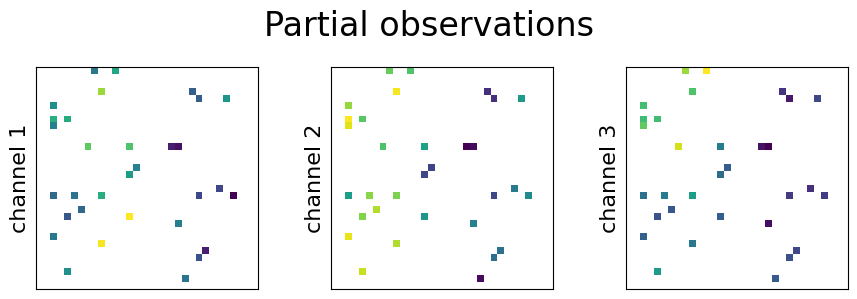

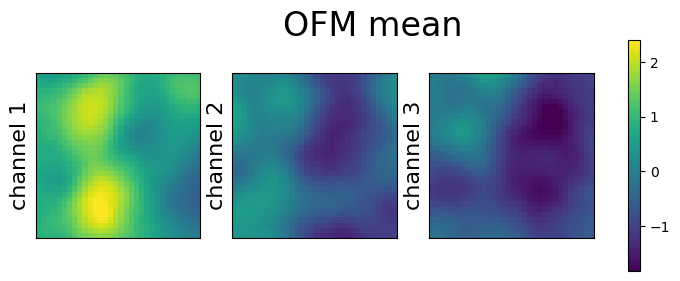

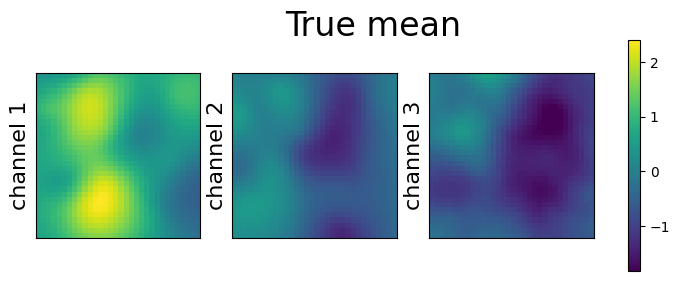

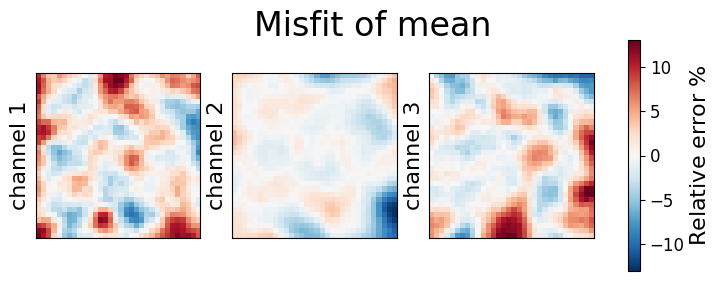

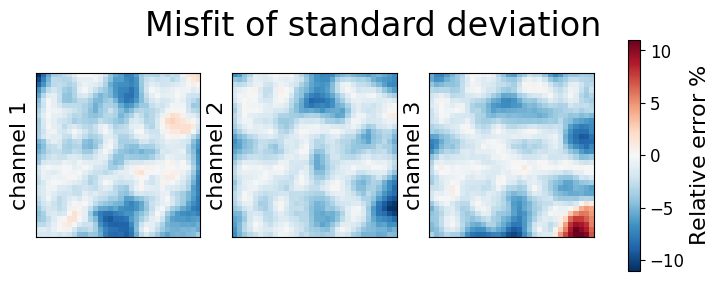

In [119]:
fig, axs = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('Partial observations', fontsize=24)
axs[0].imshow(part_gt_1)
axs[0].set_ylabel('channel 1', fontsize=16)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(part_gt_2)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_ylabel('channel 2', fontsize=16)

axs[2].imshow(part_gt_3)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_ylabel('channel 3', fontsize=16)
plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_3C_partial_obs.pdf")


fig, axs = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('OFM mean', fontsize=24)

axs[0].imshow(sample_mean_0, vmin=y_min_plot, vmax=y_max_plot)
axs[0].set_ylabel('channel 1', fontsize=16)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(sample_mean_1, vmin=y_min_plot, vmax=y_max_plot)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_ylabel('channel 2', fontsize=16)

axs[2].imshow(sample_mean_2, vmin=y_min_plot, vmax=y_max_plot)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_ylabel('channel 3', fontsize=16)

bar = axs[2].imshow(sample_mean_2, vmin=y_min_plot, vmax=y_max_plot)
fig.colorbar(bar, ax=axs)  

#plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_3C_ofm_mean.pdf")

fig, axs = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('True mean', fontsize=24)

axs[0].imshow(y_mean_0, vmin=y_min_plot, vmax=y_max_plot)
axs[0].set_ylabel('channel 1', fontsize=16)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(y_mean_1, vmin=y_min_plot, vmax=y_max_plot)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_ylabel('channel 2', fontsize=16)

axs[2].imshow(y_mean_2, vmin=y_min_plot, vmax=y_max_plot)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_ylabel('channel 3', fontsize=16)
bar = axs[2].imshow(sample_mean_2, vmin=y_min_plot, vmax=y_max_plot)
fig.colorbar(bar, ax=axs) 

#plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_3C_true_mean.pdf")




######################################################
## Misfit of mean and std for each channel
fig, axs = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('Misfit of mean', fontsize=24)

relative_error = (sample_mean_0 - y_mean_0)/y_abs_max*100
norm_1 = TwoSlopeNorm(vmin = -np.abs(relative_error).max(), vmax = np.abs(relative_error).max(), vcenter=0)
axs[0].imshow(relative_error, norm=norm_1, cmap="RdBu_r")
axs[0].set_ylabel('channel 1', fontsize=16)
axs[0].set_xticks([])
axs[0].set_yticks([])

relative_error = (sample_mean_1 - y_mean_1)/y_abs_max*100
norm_1 = TwoSlopeNorm(vmin = -np.abs(relative_error).max(), vmax = np.abs(relative_error).max(), vcenter=0)
axs[1].imshow(relative_error, norm=norm_1, cmap="RdBu_r")
axs[1].set_ylabel('channel 2', fontsize=16)
axs[1].set_xticks([])
axs[1].set_yticks([])

relative_error = (sample_mean_2 - y_mean_2)/y_abs_max*100
norm_1 = TwoSlopeNorm(vmin = -np.abs(relative_error).max(), vmax = np.abs(relative_error).max(), vcenter=0)
axs[2].imshow(relative_error, norm=norm_1, cmap="RdBu_r")
axs[2].set_ylabel('channel 3', fontsize=16)
axs[2].set_xticks([])
axs[2].set_yticks([])

bar = axs[2].imshow(relative_error, norm=norm_1, cmap="RdBu_r")

cbar = fig.colorbar(bar, ax=axs)
cbar.ax.set_ylabel(f"Relative error $\%$", fontsize=16)
cbar.ax.tick_params(labelsize=12)
#plt.tight_layout()

plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_3C_misfit_mean.pdf")

## Misfit of std
fig, axs = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('Misfit of standard deviation', fontsize=24)

relative_error = (sample_std_0 - y_std_0)/y_abs_max*100
norm_1 = TwoSlopeNorm(vmin = -np.abs(relative_error).max(), vmax = np.abs(relative_error).max(), vcenter=0)
axs[0].imshow(relative_error, norm=norm_1, cmap="RdBu_r")
axs[0].set_ylabel('channel 1', fontsize=16)
axs[0].set_xticks([])
axs[0].set_yticks([])

relative_error = (sample_std_1 - y_std_1)/y_abs_max*100
norm_1 = TwoSlopeNorm(vmin = -np.abs(relative_error).max(), vmax = np.abs(relative_error).max(), vcenter=0)
axs[1].imshow(relative_error, norm=norm_1, cmap="RdBu_r")
axs[1].set_ylabel('channel 2', fontsize=16)
axs[1].set_xticks([])
axs[1].set_yticks([])

relative_error = (sample_std_2 - y_std_2)/y_abs_max*100
norm_1 = TwoSlopeNorm(vmin = -np.abs(relative_error).max(), vmax = np.abs(relative_error).max(), vcenter=0)
axs[2].imshow(relative_error, norm=norm_1, cmap="RdBu_r")
axs[2].set_ylabel('channel 3', fontsize=16)
axs[2].set_xticks([])
axs[2].set_yticks([])

bar = axs[2].imshow(relative_error, norm=norm_1, cmap="RdBu_r")

cbar = fig.colorbar(bar, ax=axs)
cbar.ax.set_ylabel(f"Relative error $\%$", fontsize=16)
cbar.ax.tick_params(labelsize=12)
#plt.tight_layout()
plt.savefig(f"../Regression_results/{saved_folder}/GRF_reg_3C_misfit_std.pdf")

In [125]:
import h5py
f = h5py.File(f"../Regression_results/{saved_folder}/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=mask_idx)
f.create_dataset('noise_patter', data=noise_pattern.detach().cpu().numpy().squeeze())
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()